# Fine-grained performance figures

Notebook to generate categorical plots across CLRS30, GSM8K, NPHardEval, and other fine-grained tasks, highlighting arm trends (code > code_sim > nl) and model categories.


In [1]:
import re
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import wilcoxon

from src.exps_performance.logger import create_big_df, walk_results_folder

FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(exist_ok=True)

ARM_ORDER = ["code_correct", "controlsim_correct", "sim_correct", "nl_correct"]
ARM_NAME_MAP = {
    "nl_correct": "Arm 1 (NL)",
    "sim_correct": "Arm 2 (Code Sim)",
    "controlsim_correct": "Arm 2.5 (Controlled Code Sim)",
    "code_correct": "Arm 3 (Code Exec)",
}

CLRS30_KINDS = {"add", "mul", "lcs", "rod"}
NPHARD_KINDS = {"knap", "ilp_assign", "ilp_partition", "ilp_prod", "gcp", "ksp", "spp", "tsp", "sub", "edp"}
GSM8K_KINDS = {"gsm8k"}

In [2]:
# Lightweight manual overrides; extend as needed
MODEL_META_OVERRIDES: Dict[str, Dict[str, str]] = {
    "anthropic/claude-haiku-4.5": {
        "openness": "closed",
        "model_family": "reasoning",
        "post_training": "RLHF",
        "provider": "anthropic",
        "size_b": "4.5",
    },
    "deepseek/deepseek-r1": {
        "openness": "closed",
        "model_family": "reasoning",
        "post_training": "RL-like",
        "provider": "deepseek",
        "size_b": "",
    },
    "deepseek/deepseek-r1-distill-llama-70b": {
        "openness": "open",
        "model_family": "reasoning",
        "post_training": "distill/SFT",
        "provider": "deepseek",
        "size_b": "70",
    },
    "google/gemini-2.0-flash-lite-001": {
        "openness": "closed",
        "model_family": "general",
        "post_training": "RLHF",
        "provider": "google",
        "size_b": "",
    },
    "openai/gpt-5-nano": {
        "openness": "closed",
        "model_family": "general",
        "post_training": "RLHF",
        "provider": "openai",
        "size_b": "",
    },
    "openai/gpt-oss-120b": {
        "openness": "open",
        "model_family": "general",
        "post_training": "RLHF",
        "provider": "openai",
        "size_b": "120",
    },
    "openai/gpt-oss-20b": {
        "openness": "open",
        "model_family": "general",
        "post_training": "RLHF",
        "provider": "openai",
        "size_b": "20",
    },
    "meta-llama/llama-3-70b-instruct": {
        "openness": "open",
        "model_family": "general",
        "post_training": "RLHF",
        "provider": "meta",
        "size_b": "70",
    },
    "meta-llama/llama-3.1-405b-instruct": {
        "openness": "closed",
        "model_family": "general",
        "post_training": "RLHF",
        "provider": "meta",
        "size_b": "405",
    },
    "meta-llama/llama-4-scout": {
        "openness": "closed",
        "model_family": "general",
        "post_training": "RLHF",
        "provider": "meta",
        "size_b": "",
    },
    "mistralai/ministral-14b-2512": {
        "openness": "open",
        "model_family": "general",
        "post_training": "RLHF",
        "provider": "mistral",
        "size_b": "14",
    },
    "allenai/olmo-2-0325-32b-instruct": {
        "openness": "open",
        "model_family": "general",
        "post_training": "SFT",
        "provider": "allenai",
        "size_b": "32",
    },
    "microsoft/phi-4-reasoning-plus": {
        "openness": "closed",
        "model_family": "reasoning",
        "post_training": "RLHF",
        "provider": "microsoft",
        "size_b": "",
    },
    "qwen/qwen-2.5-72b-instruct": {
        "openness": "open",
        "model_family": "general",
        "post_training": "RLHF",
        "provider": "qwen",
        "size_b": "72",
    },
    "qwen/qwen-2.5-coder-32b-instruct": {
        "openness": "open",
        "model_family": "coding",
        "post_training": "RLHF",
        "provider": "qwen",
        "size_b": "32",
    },
}

In [3]:
def _parse_size_b(model: str) -> float:
    base = model.split("/")[-1]
    match = re.search(r"([0-9]+\.?[0-9]*)b", base, re.IGNORECASE)
    if match:
        try:
            return float(match.group(1))
        except Exception:
            return -1.0
    return -1.0


def _size_bucket(size_b: float) -> str:
    if size_b <= 0:
        return "unknown"
    if size_b < 15:
        return "<15B"
    if size_b < 35:
        return "15-35B"
    if size_b < 80:
        return "35-80B"
    if size_b < 200:
        return "80-200B"
    return "200B+"


def infer_model_metadata(model: str) -> Dict[str, str]:
    meta = MODEL_META_OVERRIDES.get(model, {}).copy()
    size_b = meta.get("size_b")
    numeric_size = float(size_b) if size_b not in ("", None) else _parse_size_b(model)

    meta.setdefault("provider", model.split("/")[0] if "/" in model else "unknown")
    meta.setdefault("openness", "open")
    meta.setdefault("model_family", "general")
    meta.setdefault("post_training", "unknown")
    meta.setdefault("size_b", "" if numeric_size <= 0 else str(numeric_size))
    meta["size_bucket"] = _size_bucket(numeric_size)
    meta["base_model"] = model
    return meta


def annotate_df_with_metadata(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    unique_models = sorted(df["model"].unique())
    meta_rows = {m: infer_model_metadata(m) for m in unique_models}
    meta_df = pd.DataFrame(meta_rows).T.reset_index(drop=True)
    df = df.merge(meta_df, left_on="model", right_on="base_model", how="left")
    for col, default in (
        ("size_bucket", "unknown"),
        ("openness", "unknown"),
        ("model_family", "general"),
        ("post_training", "unknown"),
        ("provider", "unknown"),
    ):
        df[col] = df[col].fillna(default)
    return df


def _map_dataset_group(kind: str) -> str:
    if kind in GSM8K_KINDS:
        return "GSM8K"
    if kind in CLRS30_KINDS:
        return "CLRS30"
    if kind in NPHARD_KINDS:
        return "NPHardEval"
    return "Fine-grained"


def prepare_arm_long_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["dataset_group"] = df["kind"].map(_map_dataset_group)
    df = df[df["dataset_group"].notna()]

    present_arms = [arm for arm in ARM_ORDER if arm in df.columns]
    renamed = {k: v for k, v in ARM_NAME_MAP.items() if k in present_arms}
    df = df.rename(columns=renamed)
    arm_cols = list(renamed.values())

    long_df = pd.melt(
        df,
        value_vars=arm_cols,
        id_vars=[
            "model",
            "seed",
            "kind",
            "digit",
            "dataset_group",
            "openness",
            "model_family",
            "post_training",
            "size_bucket",
            "provider",
        ],
    )
    long_df = long_df.replace([np.inf, -np.inf], np.nan)
    long_df = long_df[np.isfinite(long_df["value"])]
    long_df["variable"] = pd.Categorical(long_df["variable"], categories=arm_cols, ordered=True)
    return long_df

In [4]:
def plot_dataset_arm_trends(long_df: pd.DataFrame):
    sns.reset_defaults()
    g = sns.FacetGrid(long_df, col="dataset_group", col_wrap=2, hue="variable", sharex=False, sharey=False, height=4)
    g.map_dataframe(sns.lineplot, x="digit", y="value")
    g.map_dataframe(sns.scatterplot, x="digit", y="value", s=10)
    g.set_titles("{col_name}")
    g.set_axis_labels("Test length (digit)", "Accuracy")
    g.add_legend(title="Arm")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "arm_trends_by_dataset.png", bbox_inches="tight")
    return g


def plot_category_summary(long_df: pd.DataFrame, category_col: str, fname: str):
    sns.reset_defaults()
    summary = long_df.groupby(["dataset_group", category_col, "variable"])["value"].mean().reset_index().sort_values(by="value", ascending=False)
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=summary,
        x="dataset_group",
        y="value",
        hue=category_col,
        palette="tab20",
        errorbar=None,
    )
    ax.set_ylabel("Mean accuracy")
    ax.set_xlabel("Dataset group")
    ax.set_title(f"Accuracy by {category_col.replace('_', ' ').title()} and dataset")
    plt.legend(title=category_col)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / fname, bbox_inches="tight")
    return ax


def plot_arm_delta(long_df: pd.DataFrame):
    pivot = (
        long_df.pivot_table(
            index=["model", "dataset_group", "digit"],
            columns="variable",
            values="value",
            aggfunc="mean",
        )
        .reset_index()
        .dropna()
    )
    pivot["code_minus_sim"] = pivot.get("Arm 3 (Code Exec)", pd.Series(dtype=float)) - pivot.get("Arm 2 (Code Sim)", pd.Series(dtype=float))
    pivot["sim_minus_nl"] = pivot.get("Arm 2 (Code Sim)", pd.Series(dtype=float)) - pivot.get("Arm 1 (NL)", pd.Series(dtype=float))

    melted = pd.melt(
        pivot,
        id_vars=["model", "dataset_group", "digit"],
        value_vars=["code_minus_sim", "sim_minus_nl"],
        var_name="delta",
        value_name="value",
    )
    melted = melted[np.isfinite(melted["value"])]
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(data=melted, x="dataset_group", y="value", hue="delta", palette="coolwarm")
    ax.axhline(0, linestyle="--", color="gray", linewidth=1)
    ax.set_ylabel("Accuracy delta")
    ax.set_xlabel("Dataset group")
    ax.set_title("Arm deltas (positive favors later arms)")
    plt.legend(title="Delta")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "arm_deltas.png", bbox_inches="tight")
    return ax


import itertools


def plot_p_vals(df: pd.DataFrame):
    name_map = {
        "nl_correct": "Arm 1 (NL)",
        "sim_correct": "Arm 2 (Code Sim)",
        "controlsim_correct": "Arm 2.5 (Controlled Code Sim)",
        "code_correct": "Arm 3 (Code Exec)",
    }
    dfnew = df.rename(columns=name_map)
    cols = list(name_map.values())
    mdf = pd.melt(dfnew, value_vars=cols, id_vars=["model", "kind"])
    mdf1 = mdf.groupby(["variable", "model", "kind"]).mean().reset_index()
    mdf2 = mdf1.drop(["model", "kind"], axis=1)
    mdf2 = mdf2[np.isfinite(mdf2["value"])]
    arm_pairs = list(itertools.combinations(cols, 2))

    def wilcoxon_test(local_df: pd.DataFrame, pairs: List[tuple[str, str]]):
        p_values = []
        for pair in pairs:
            x = local_df[local_df["variable"] == pair[0]]["value"]
            y = local_df[local_df["variable"] == pair[1]]["value"]
            try:
                _, p_value = wilcoxon(x, y)
            except Exception:
                p_value = 1.0
            p_values.append(p_value)
        return p_values

    p_values = wilcoxon_test(mdf2, arm_pairs)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.boxplot(x="variable", y="value", data=mdf2, gap=0.3, palette=sns.color_palette("vlag", n_colors=8)[:4], ax=ax)
    offset = 0
    max_val = mdf2["value"].max()
    if pd.isna(max_val):
        max_val = 0.0
    for i, pair in enumerate(arm_pairs):
        order = {x: idx for idx, x in enumerate(cols)}
        x1, x2 = order[pair[0]], order[pair[1]]
        y = max_val + offset
        h = 0.03
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="steelblue")
        ax.text((x1 + x2) * 0.5, y + h, f"p={p_values[i]:.4f}", ha="center", va="bottom")
        offset += 0.08
    ax.set_ylim(0, max(1.0, y + 0.5))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Arms")
    ax.set_title("Accuracy across Arms on Fine-grained Tasks")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "pval.png", bbox_inches="tight")
    return ax

In [5]:
# Load data
results_root = Path("/nlpgpu/data/terry/ToolProj/src/exps_performance/results")
jsonl_files = walk_results_folder(str(results_root))
if not jsonl_files:
    raise FileNotFoundError(f"No JSONL files found under {results_root}")

raw_df = create_big_df(jsonl_files)
raw_df.head()

,request_id,unique_tag,index_in_kind,model,seed,exp_id,digit,kind,question,answer,...,sim_correct,sim_parse_err,sim_err_msg,controlsim_question,controlsim_reasoning,controlsim_answer,controlsim_correct,controlsim_parse_err,controlsim_err_msg,Unnamed: 0
0,05fc3aea7f3298ca7e21c8c7108f71b9fd75b2db,a64255c0f1c72e185b9def827356e94c487749f9,1.0,qwen/qwen-2.5-coder-32b-instruct,1,run_20251209_044045,0,gsm8k,Janet’s ducks lay 16 eggs per day. She eats th...,18,...,False,"Invalid json output: <think>\nOkay, let's see....","Invalid json output: <think>\nOkay, let's see....",Simulate the execution of the provided code: ...,,"<think>\nOkay, let's try to figure out what th...",False,False,ok,NaN
1,96924c82ff316287a08f0f707d691cd95f7ba233,f0b490d61573c9e22cc5fa4bfcbcbcc8ef939bf5,2.0,qwen/qwen-2.5-coder-32b-instruct,1,run_20251209_044045,0,gsm8k,A robe takes 2 bolts of blue fiber and half th...,3,...,True,ok,ok,Simulate the execution of the provided code: `...,,"<think>\nOkay, let's see. I need to simulate t...",False,True,"Invalid json output: <think>\nOkay, let's try ...",NaN
2,631c78b323c3ce28b0f9da323fce4b6dee945e10,ca8ae5a4309e87b8ad95f7a67aac2cec374e6d92,3.0,qwen/qwen-2.5-coder-32b-instruct,1,run_20251209_044045,0,gsm8k,Josh decides to try flipping a house. He buys...,70000,...,False,ok,ok,Simulate the execution of the provided code: ...,,"<think>\nOkay, let's see. The user provided a ...",False,True,Invalid json output: To simulate the execution...,NaN
3,20cf29789c0eb9a925bdf0c9a6fe0c8438c4d157,0c3a0e71ce11ebef19185db7532f4d1790437f24,4.0,qwen/qwen-2.5-coder-32b-instruct,1,run_20251209_044045,0,gsm8k,James decides to run 3 sprints 3 times a week....,540,...,False,ok,ok,Simulate the execution of the provided code: ...,,"<think>\nOkay, let's see. The user wants me to...",False,True,"Invalid json output: <think>\nOkay, let me try...",NaN
4,a9c7462655570c6c619f33fa4a53f2c8fc87d65d,835c30a36ec7e58a2ee43672fbd50cbdceef6f8b,5.0,qwen/qwen-2.5-coder-32b-instruct,1,run_20251209_044045,0,gsm8k,"Every day, Wendi feeds each of her chickens th...",20,...,False,ok,ok,Simulate the execution of the provided code: ...,,"<think>\nOkay, let's see. The user wants me to...",False,True,"Invalid json output: <think>\nOkay, let's see....",NaN


In [6]:
# Prepare metadata and long format
ann_df = annotate_df_with_metadata(raw_df)
long_df = prepare_arm_long_df(ann_df)
long_df.head()

,model,seed,kind,digit,dataset_group,openness,model_family,post_training,size_bucket,provider,variable,value
0,qwen/qwen-2.5-coder-32b-instruct,1,gsm8k,0,GSM8K,open,coding,RLHF,15-35B,qwen,Arm 1 (NL),False
1,qwen/qwen-2.5-coder-32b-instruct,1,gsm8k,0,GSM8K,open,coding,RLHF,15-35B,qwen,Arm 1 (NL),False
2,qwen/qwen-2.5-coder-32b-instruct,1,gsm8k,0,GSM8K,open,coding,RLHF,15-35B,qwen,Arm 1 (NL),True
3,qwen/qwen-2.5-coder-32b-instruct,1,gsm8k,0,GSM8K,open,coding,RLHF,15-35B,qwen,Arm 1 (NL),True
4,qwen/qwen-2.5-coder-32b-instruct,1,gsm8k,0,GSM8K,open,coding,RLHF,15-35B,qwen,Arm 1 (NL),False


/tmp/ipykernel_8839/2899159895.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  long_df.groupby(["dataset_group", category_col, "variable"])["value"]
/tmp/ipykernel_8839/2899159895.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  long_df.groupby(["dataset_group", category_col, "variable"])["value"]
/tmp/ipykernel_8839/2899159895.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  long_df.groupby(["dataset_group"

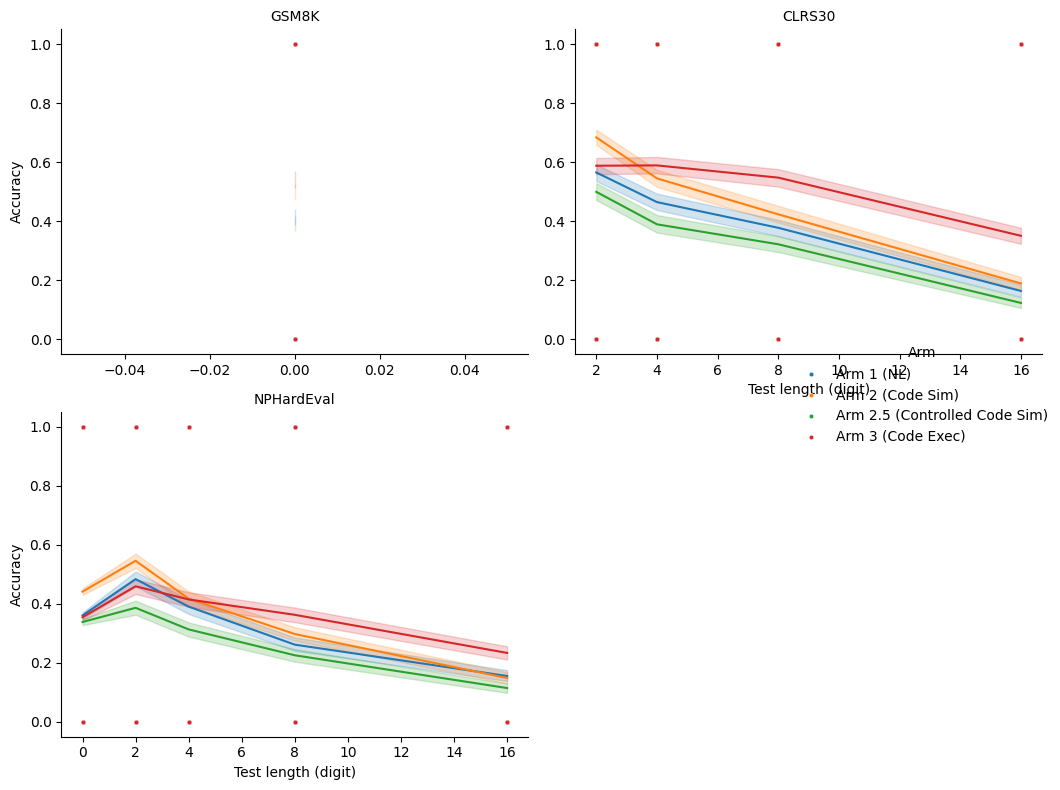

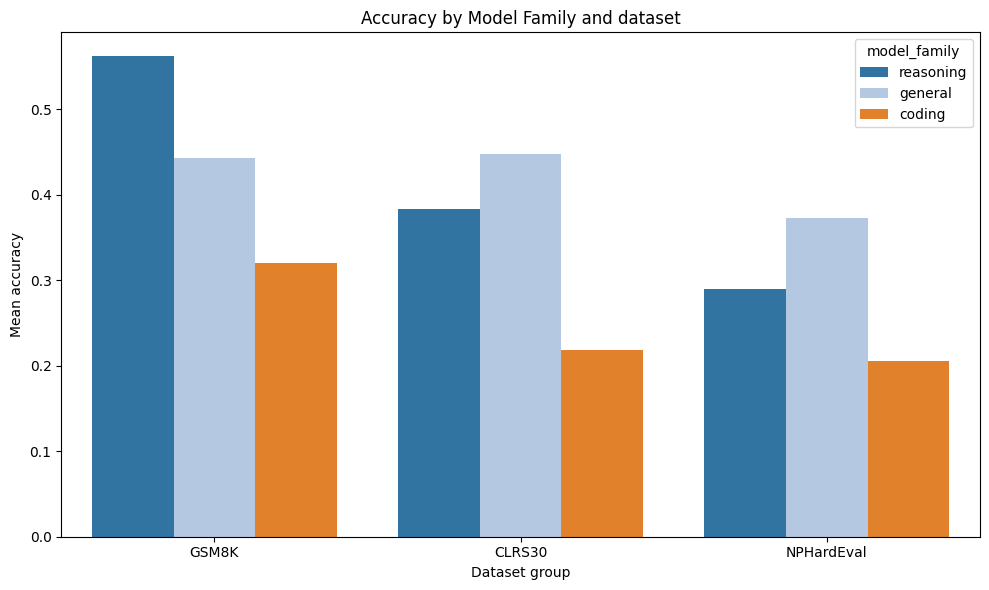

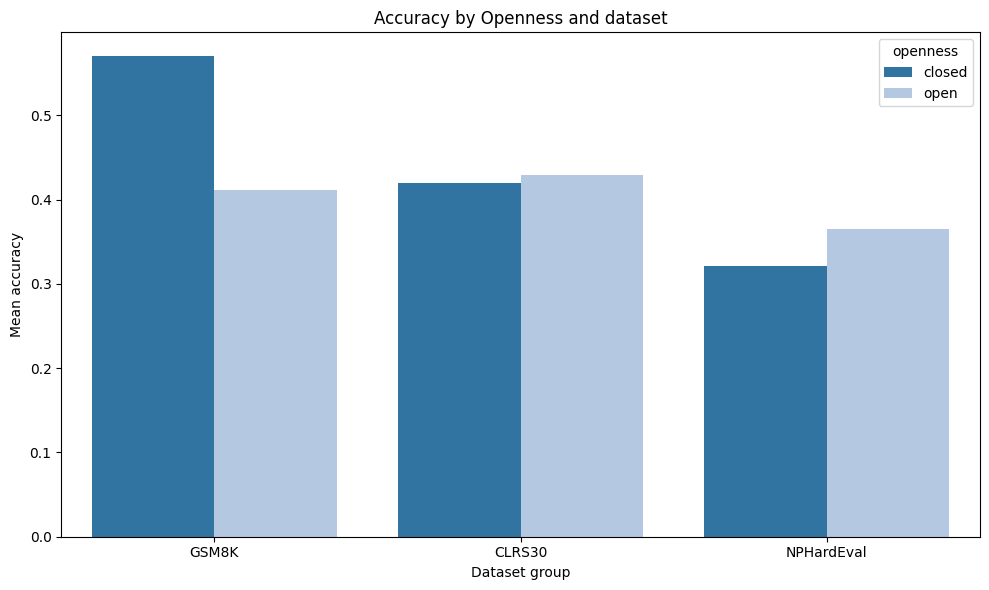

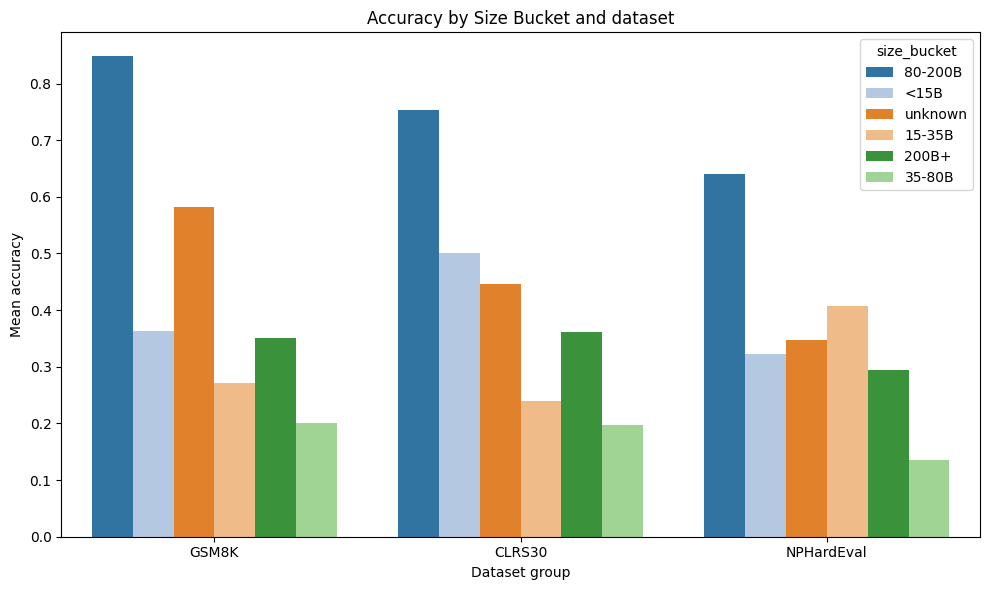

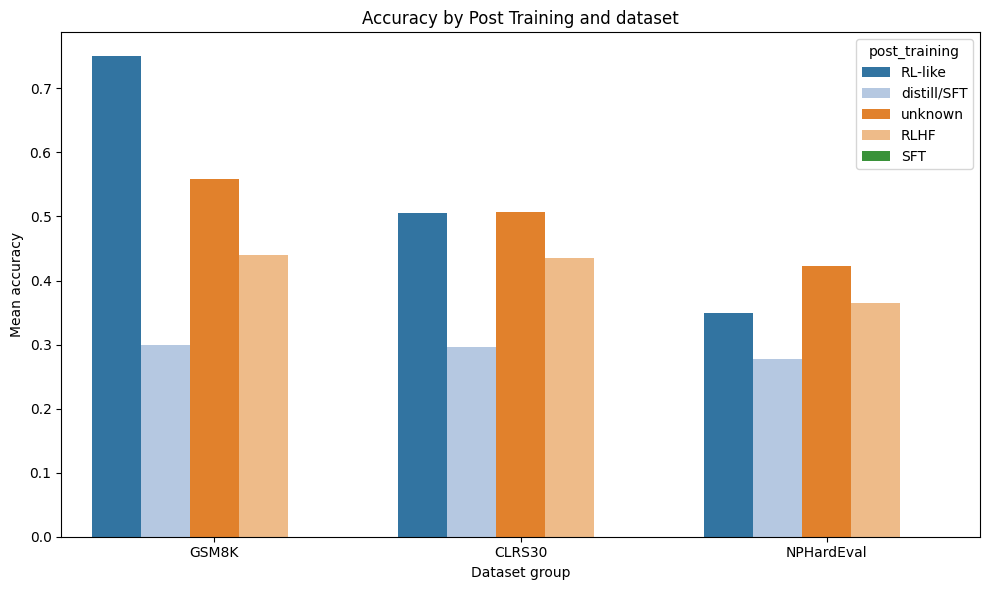

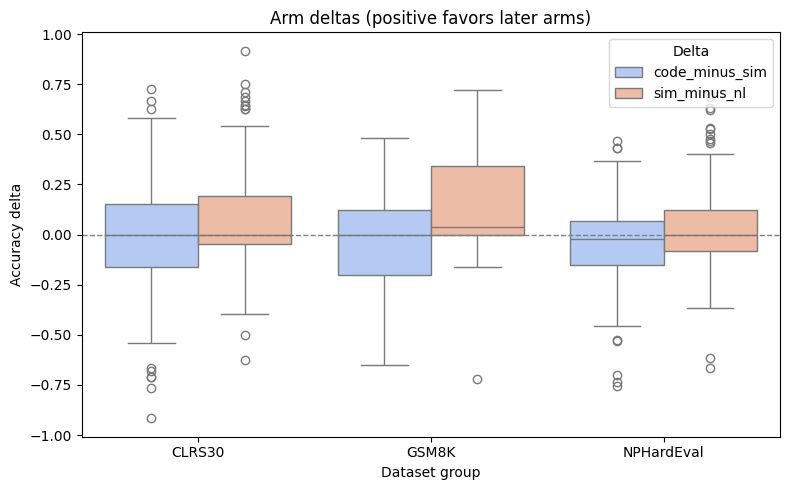

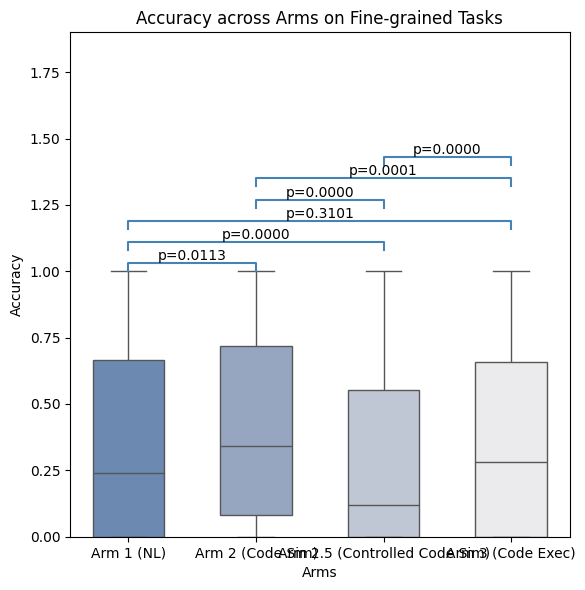

In [7]:
# Plot suite (figures saved under figures/ and displayed inline)
plot_dataset_arm_trends(long_df)
plot_category_summary(long_df, "model_family", "arm_by_family.png")
plot_category_summary(long_df, "openness", "arm_by_openness.png")
plot_category_summary(long_df, "size_bucket", "arm_by_size.png")
plot_category_summary(long_df, "post_training", "arm_by_posttrain.png")
plot_arm_delta(long_df)
plot_p_vals(ann_df)
plt.show()